In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

# A general overview of impact of armed conflicts on agriculture

## Wars Dataframe creation

The data about wars have been downloaded from Wikidata, using the query in the [get_wiki_data.py](get_wiki_data.py) file. We run three different queries, in order to differentiate between different participants: state, and non-state. Since we could not find any way to have all the participants, differentiating between the different kinds, we decided to run three different queries: one for states, one for political organizations and one for terroristic organizations. The line that needs to be changed is `?participant (wdt:P31/wdt:P279*) wd:Q7275.`. For States, we used `wd:Q7275`, for political organizations we used `wd:Q7210356` and for terroristic organizations we used `wd:Q17127659`.

First, let us import the dataframes containing information about the wars, with participants. There are three different dataframes: one for states, one for political organizations and one for terroristic organizations.

In [20]:
wikipedia_path = '../data/wikipedia/'
state_in_war_file = 'states.json'
political_in_war_file = 'political.json'
terroristic_in_war_file = 'terroristic.json'

wars_states_df = pd.read_json(wikipedia_path + state_in_war_file, orient='records', encoding='utf-8')
wars_political_df = pd.read_json(wikipedia_path + political_in_war_file, orient='records', encoding='utf-8')
wars_terroristic_df = pd.read_json(wikipedia_path + terroristic_in_war_file, orient='records', encoding='utf-8')

Since, at least for the moment, we are not interested in the difference between these three categories, but only between state and non-state actors, we only mark whether a participant is state or non-state. Next we stack the dataframes to create a unique one.

In [21]:
wars_states_df['state'] = True
wars_political_df['state'] = False
wars_terroristic_df['state'] = False

raw_wars_df = wars_states_df.append(wars_political_df, sort=True).append(wars_terroristic_df, sort=True)

renamed_wars_df = raw_wars_df.rename(columns={
    'armed_conflictLabel': 'name',
    'participantLabel': 'participant',
    'countryWarLabel': 'country',
    'locationLabel': 'location'
})

renamed_wars_df.loc[renamed_wars_df['end_year'].isnull(), 'end_year'] = 2019

renamed_wars_df['start_year'] = pd.to_datetime(renamed_wars_df['start_year'], format='%Y')
renamed_wars_df['end_year'] = pd.to_datetime(renamed_wars_df['end_year'], format='%Y')

renamed_wars_df.head()

,name,country,end_year,location,participant,start_year,state
0,Croatian War of Independence,Croatia,1995-01-01,Croatia,Socialist Federal Republic of Yugoslavia,1991-01-01,True
1,Croatian War of Independence,Croatia,1995-01-01,Croatia,Republic of Bosnia and Herzegovina,1991-01-01,True
2,Croatian War of Independence,Croatia,1995-01-01,Croatia,Croatia,1991-01-01,True
3,Croatian War of Independence,Croatia,1995-01-01,Croatia,Republika Srpska,1991-01-01,True
4,Croatian War of Independence,Croatia,1995-01-01,Croatia,Republic of Serbian Krajina,1991-01-01,True


Now, let us see if there is any missing value:

In [22]:
renamed_wars_df[renamed_wars_df.isnull().any(axis=1)].groupby('name').count().shape[0]

20

In [23]:
renamed_wars_df[renamed_wars_df['country'].isnull()].groupby('name').count()

,country,end_year,location,participant,start_year,state
name,,,,,,
1982 Ethiopian–Somali Border War,0,3,0,3,3,3
2006 Lebanon War,0,4,4,4,4,4
Cambodian Civil War,0,14,14,14,14,14
Ceneps Guar,0,2,0,2,2,2
Djiboutian Civil War,0,2,0,2,2,2
First Congo War,0,8,8,8,8,8
Gaza–Israel clashes (May 2019),0,4,4,4,4,4
Gaza–Israel conflict,0,4,0,4,4,4
Insurgency in the Maghreb (2002–),0,15,15,15,15,15


Since there are not many missing wars, we can set the countries manually, based on the location and on the conflict Wikipedia page. We use the modern state where the location is situated.

In [24]:
non_null_wars_df = renamed_wars_df.copy()

# Fix missing country
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tet Offensive', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Kosovo War', 'country'] = 'Kosovo'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Soviet–Afghan War', 'country'] = 'Afghanistan'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Cambodian Civil War', 'country'] = 'Cambodia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'First Congo War', 'country'] = 'Democratic Republic of the Congo'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Djiboutian Civil War', 'country'] = 'Djibouti'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Libyan–Egyptian War', 'country'] = 'Lybia,Egypt'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Paquisha War', 'country'] = 'Ecuador,Peru'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Sino-Vietnamese War', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == '1982 Ethiopian–Somali Border War', 'country'] = 'Somalia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Ceneps Guar', 'country'] = 'Ecuador,Peru'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Second Kurdish–Iraqi War', 'country'] = 'Iraq'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Vietnam War', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Six-Day War', 'country'] = 'Israel,Egypt,Palestine,Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tell Abyad offensive', 'country'] = 'Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == '2006 Lebanon War', 'country'] = 'Lebanon,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel clashes (May 2019)', 'country'] = 'Israel,Palestine'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tell Abyad offensive', 'country'] = 'Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == '2006 Lebanon War', 'country'] = 'Lebanon,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel clashes (May 2019)', 'country'] = 'Israel,Palestine'
non_null_wars_df.loc[non_null_wars_df['name'] == '2003 invasion of Iraq', 'country'] = 'Iraq'
non_null_wars_df.loc[non_null_wars_df['name'] == '2014 Israel–Gaza conflict', 'country'] = 'Palestine,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == '2018–19 Gaza border protests', 'country'] = 'Palestine,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Croatian War of Independence', 'country'] = 'Croatia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel conflict', 'country'] = 'Palestine, Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Insurgency in the Maghreb (2002–)', 'country'] = '''
    Algeria,Libya,Mauritania,Morocco,Tunisia,Western Sahara'''
non_null_wars_df.loc[non_null_wars_df['name'] == "Lord's Resistance Army insurgency", 'country'] = '''
    Uganda,South Sudan,Democratic Republic of the Congo,Central African Republic'''

In [25]:
# Eplode entries with multiple locations
non_null_wars_df['country'] = non_null_wars_df['country'].str.split(',')
exploded_wars_df = non_null_wars_df.reset_index().explode('country').drop('index', axis=1)
stripped_wars_df = exploded_wars_df.copy()
stripped_wars_df['country'] = exploded_wars_df['country'].str.strip()

Let us see what is left:

In [26]:
stripped_wars_df[stripped_wars_df['country'].isnull()]

,name,country,end_year,location,participant,start_year,state
767,War on Terror,NaN,2019-01-01,NaN,People's Republic of China,2001-01-01,True
768,War on Terror,NaN,2019-01-01,NaN,France,2001-01-01,True
769,War on Terror,NaN,2019-01-01,NaN,Islamic State of Iraq and the Levant,2001-01-01,True
770,War on Terror,NaN,2019-01-01,NaN,Russia,2001-01-01,True
771,War on Terror,NaN,2019-01-01,NaN,United Kingdom,2001-01-01,True
772,War on Terror,NaN,2019-01-01,NaN,United States of America,2001-01-01,True
1059,War on Terror,NaN,2019-01-01,NaN,Islamic State of Iraq and the Levant,2001-01-01,False
1060,War on Terror,NaN,2019-01-01,NaN,Taliban,2001-01-01,False
1061,War on Terror,NaN,2019-01-01,NaN,Turkistan Islamic Party,2001-01-01,False
1086,War on Terror,NaN,2019-01-01,NaN,Islamic State of Iraq and the Levant,2001-01-01,False


Since the [War on Terror](https://en.wikipedia.org/wiki/War_on_Terror) can be considered as a series of war, and has no defined location, we drop it.

In [27]:
final_wars_df = stripped_wars_df[stripped_wars_df['name'] != 'War on Terror']

In [28]:
final_wars_df[final_wars_df['country'].isnull()]

,name,country,end_year,location,participant,start_year,state


In [29]:
final_wars_df.groupby('country').count()

,name,end_year,location,participant,start_year,state
country,,,,,,
Afghanistan,24,24,24,24,24,24
Algeria,20,20,20,20,20,20
Angola,15,15,15,15,15,15
Armenia,24,24,24,24,24,24
Artsakh,26,26,26,26,26,26
...,...,...,...,...,...,...
United Arab Emirates,30,30,30,30,30,30
United Kingdom,4,4,4,4,4,4
Vietnam,10,10,10,10,10,10


## Agricultural production dataframe creation

In [30]:
fao_path = '../data/fao/'
crops_file = 'crops_production.csv'

raw_crops_production_df = pd.read_csv(fao_path + crops_file)
raw_crops_production_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1961,1961,tonnes,3695000.0,A,"Aggregate, may include official, semi-official..."
1,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1962,1962,tonnes,3696000.0,A,"Aggregate, may include official, semi-official..."
2,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1963,1963,tonnes,3378000.0,A,"Aggregate, may include official, semi-official..."
3,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1964,1964,tonnes,3732000.0,A,"Aggregate, may include official, semi-official..."
4,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1965,1965,tonnes,3785000.0,A,"Aggregate, may include official, semi-official..."


Let us see the different elements in some features, in order to decide if we can drop them:

In [31]:
raw_crops_production_df.groupby('Flag').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag Description
Flag,,,,,,,,,,,,,
A,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669


In [32]:
raw_crops_production_df.groupby('Unit').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Value,Flag,Flag Description
Unit,,,,,,,,,,,,,
tonnes,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


In [33]:
raw_crops_production_df.groupby('Element').count()

,Domain Code,Domain,Area Code,Area,Element Code,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
Element,,,,,,,,,,,,,
Production,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


In [34]:
raw_crops_production_df.groupby('Domain').count()

,Domain Code,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
Domain,,,,,,,,,,,,,
Crops,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


Since we have only one value for those columns, we can drop them. We just need to keep in mind that the unit used is tonnes. Let us drop useless columns, and rename the remaing ones to be more consistent with the wars dataframe naming.

In [35]:
crops_production_df = raw_crops_production_df.drop(columns=[
    'Domain Code',
    'Area Code',
    'Domain',
    'Element Code',
    'Element',
    'Item Code',
    'Year Code',
    'Unit',
    'Flag',
    'Flag Description'
])

crops_production_df = crops_production_df.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Year': 'year',
    'Value': 'value'
})

crops_production_df['year'] = pd.to_datetime(crops_production_df['year'], format='%Y')

Now, let us see if there are missing values:

In [36]:
crops_production_df[crops_production_df.isnull().any(axis=1)]

,country,item,year,value
3994,Armenia,"Oilcrops, Cake Equivalent",1993-01-01,NaN
3995,Armenia,"Oilcrops, Cake Equivalent",1994-01-01,NaN
3996,Armenia,"Oilcrops, Cake Equivalent",1995-01-01,NaN
3997,Armenia,"Oilcrops, Cake Equivalent",1996-01-01,NaN
3998,Armenia,"Oilcrops, Cake Equivalent",1997-01-01,NaN
...,...,...,...,...
102568,Zimbabwe,"Treenuts,Total",1974-01-01,NaN
102569,Zimbabwe,"Treenuts,Total",1975-01-01,NaN
102570,Zimbabwe,"Treenuts,Total",1976-01-01,NaN
102571,Zimbabwe,"Treenuts,Total",1977-01-01,NaN


We can see that many values are missing. We will deal with it later. For the moment we will map them to 0 to have a general overview.

In [37]:
crops_production_df.loc[crops_production_df['value'].isnull(), 'value'] = 0

Some countries, like Vietnam, have slightly different names. Let us rename them:

In [38]:
crops_production_df.loc[crops_production_df['country'] == 'Viet Nam', 'country'] = 'Vietnam'
crops_production_df.loc[crops_production_df['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'
crops_production_df.loc[crops_production_df['country'] == 'Russian Federation', 'country'] = 'Russia'

Now let us compute the total production per year per country:

In [39]:
prod_per_year_per_country = (
    crops_production_df.groupby(['country', 'year'])
        .sum()
        .reset_index()
)

prod_per_year_per_country.head()

,country,year,value
0,Afghanistan,1961-01-01,5909080.0
1,Afghanistan,1962-01-01,5934534.0
2,Afghanistan,1963-01-01,5686583.0
3,Afghanistan,1964-01-01,6147934.0
4,Afghanistan,1965-01-01,6274668.0


Let us plot the general trend:

C:\Users\micha\Anaconda3\envs\ada\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


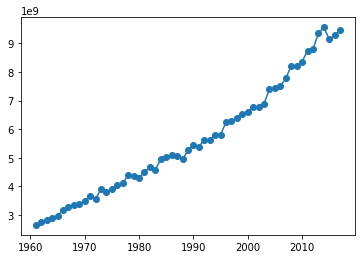

In [40]:
prod_per_year = prod_per_year_per_country.groupby('year').sum().reset_index()
plt.plot_date(x=prod_per_year['year'], y=prod_per_year['value'], linestyle="-", xdate=True)

Now, let us plot the trend for one of the countries that has been affected by war the most, Afghanistan:

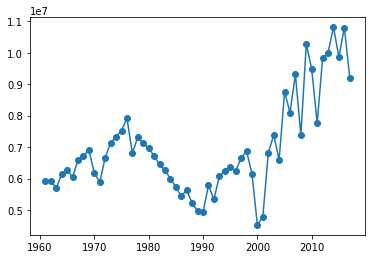

In [41]:
afghanistan_production = (
    prod_per_year_per_country[prod_per_year_per_country['country'] == 'Afghanistan']
        .drop('country', axis=1)
)

_ = plt.plot_date(x=afghanistan_production['year'], y=afghanistan_production['value'], linestyle="-", xdate=True)

Now, let us plot the production, coloring in red the years during which a war happened.

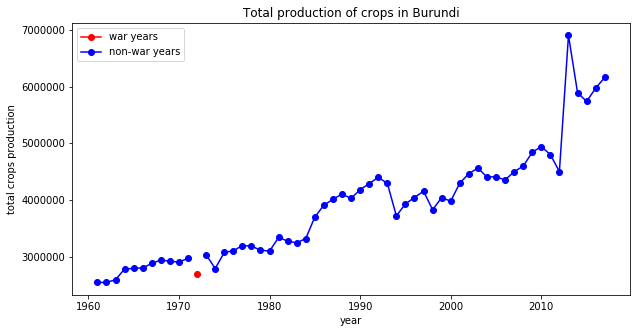

In [47]:
from src.plots import plot_production_and_war

plot_production_and_war(final_wars_df, prod_per_year_per_country, 'Burundi')

## Live Animal Population dataframe creation

In [4]:
fao_path = '../data/fao/'
animal_file = 'live_animal_population.csv'

raw_animal_population_df = pd.read_csv(fao_path + animal_file)
raw_animal_population_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1961,1961,Head,1300000.0,NaN,Official data
1,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1962,1962,Head,851850.0,NaN,Official data
2,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1963,1963,Head,1001112.0,NaN,Official data
3,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1964,1964,Head,1150000.0,F,FAO estimate
4,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1965,1965,Head,1300000.0,NaN,Official data


Let us see the different elements in some features, in order to decide if we can drop them:

In [6]:
raw_animal_population_df.groupby('Flag Description').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag
Flag Description,,,,,,,,,,,,,
"Aggregate, may include official, semi-official, estimated or calculated data",968,968,968,968,968,968,968,968,968,968,968,968,968
Data not available,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,0,2723
FAO data based on imputation methodology,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709
FAO estimate,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532
Official data,52131,52131,52131,52131,52131,52131,52131,52131,52131,52131,52131,52131,0
Unofficial figure,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290


In [8]:
raw_animal_population_df.groupby('Flag').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag Description
Flag,,,,,,,,,,,,,
*,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290
A,968,968,968,968,968,968,968,968,968,968,968,968,968
F,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532
Im,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709
M,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,0,2723


In [15]:
raw_animal_population_df.groupby('Unit').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Value,Flag,Flag Description
Unit,,,,,,,,,,,,,
1000 Head,27676,27676,27676,27676,27676,27676,27676,27676,27676,27676,26394,15941,27676
Head,69230,69230,69230,69230,69230,69230,69230,69230,69230,69230,68047,31271,69230
No,6447,6447,6447,6447,6447,6447,6447,6447,6447,6447,6189,4010,6447


We see that there are three different units used in the data. We will investigate the "1000 Head" and the "No" units to determine whether we should simply drop them or modify them.

In [48]:
raw_animal_population_df.loc[raw_animal_population_df['Unit'] == 'No'].groupby('Item').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Year Code,Year,Unit,Value,Flag,Flag Description
Item,,,,,,,,,,,,,
Beehives,6447,6447,6447,6447,6447,6447,6447,6447,6447,6447,6189,4010,6447


We see that the only Item with "No" as a unit are Beehives.

In [49]:
raw_animal_population_df.loc[raw_animal_population_df['Unit'] == '1000 Head'].groupby('Item').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Year Code,Year,Unit,Value,Flag,Flag Description
Item,,,,,,,,,,,,,
Chickens,11326,11326,11326,11326,11326,11326,11326,11326,11326,11326,11223,6133,11326
Ducks,5192,5192,5192,5192,5192,5192,5192,5192,5192,5192,4877,3089,5192
Geese and guinea fowls,2892,2892,2892,2892,2892,2892,2892,2892,2892,2892,2761,1518,2892
"Pigeons, other birds",574,574,574,574,574,574,574,574,574,574,545,370,574
Rabbits and hares,3359,3359,3359,3359,3359,3359,3359,3359,3359,3359,2944,2251,3359
"Rodents, other",114,114,114,114,114,114,114,114,114,114,114,97,114
Turkeys,4219,4219,4219,4219,4219,4219,4219,4219,4219,4219,3930,2483,4219


In [16]:
animal_population_df = raw_animal_population_df.drop(columns=[
    'Domain Code',
    'Area Code',
    'Domain',
    'Element Code',
    'Element',
    'Item Code',
    'Year Code',
    'Unit',
    'Flag',
    'Flag Description'
])

animal_population_df = animal_population_df.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Year': 'year',
    'Value': 'value'
})

animal_population_df['year'] = pd.to_datetime(animal_population_df['year'], format='%Y')